<a href="https://colab.research.google.com/github/victorcionca/5gslicing/blob/main/slicing_algs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Nemeth et al, "Efficient Service Graph Embedding...", NFV-SDN 2016

Service Graph (SG):
* functionality is implemented in network function nodes (vertices of the graph, $V(G)$) that have requirements $req_r$ for a set of resource types
* NFs are connected by links, where the links have bandwidth ($l_b$) and delay ($l_d$) requirements
* input and output enters/exits the graph at service access points (SAPs)
* optionally an SG can include _service chains_ that define QoS requirements on e2e paths of a SG
  * these requirements are _in addition_ of the per-link requirements of the SG (__why?__)

Resource graph (RG):
* nodes support a certain set of NFs, therefore there is an additional constraint to make sure that a SG node is mapped onto an RG node that supports the NF: _this could be made optional as it should be possible to install NFs on any RG node_.

Algorithm
* maps services that are modelled as graphs of network functions
  * the nodes of the graph are network functions
  * the edges are the communication
* goal
  * minimise network resource utilisation
  * maximise number of embedded SGs
* constraints
  * SG links must be mapped on a path that starts at the node hosting its source NF and end at the node hosting the destination NF
  * all the SG's NFs must be supported on the infrastructure
  * satisfy capacity constraints on node and link resources
  * satisfy link-wise latency along a mapped path
  * additionally satisfy e2e delay and bandwidth requirements.

The algorithm is greedy backtracking with coordinated node-link mapping:
* greedily map a SG node and adjacent link ("leg") together in one step; a leg is $(e_n, n), e_n \in \text{E(SG) } \text{terminates in } n \in \text{V(SG)}$

Input:
* service graph
  * networkx graph
  * nodes are either SAPs or NFs
  * NF nodes have a set of requirements
  * edges represent the communication between NFs, with bandwidth and delay requirements
* service chains (optional)
  * dictionary
  * 'path': simple path in the service graph, starting and ending at SAPs (list of nodes from the SG)
  * 'reqs': e2e requirements for bandwidth and delay
* resource graph
  * nodes are computation nodes or SAPs (RUs)
  * computation nodes have a set of resources (number of cores, storage)
  * RU nodes have a tracking area attribute that can be used to fix slices to specific cells
  * edges have bandwidth and delay

Output:
* node mapping
* link mapping.

Preprocessing
* the e2e bandwidth requirement of service chains are added to the bandwidth requirement per SG link
* the mapping of SG SAPs to RG SAPs is unambiguous: this will only stand if a network slice is associated to a certain tracking area
  * $\mu[SAP]$ is populated as part of the preprocessing
* helper structure:
  * for each service chain selects a subgraph of RG that excludes all the nodes that cannot satisfy the e2e latency requirements of the service chain
    * uses a matrix $d$ of shortest path delay between any two nodes on the RG graph
    * considering that the SAPs are already mapped to nodes, we can determine for each node $h$ of the RG graph if $d(\mu(p.first), h)+d(h,\mu(p.last))<D_p$.

## Observations

It is possible for two service chains to intersect at one node, as shown below:

```
         o------o
a     t /
o------o-------o
b     /
o----o
```

According to the algorithm these do not count as separate subchains.

Furthermore, subgraph nodes (NFs) should be embedded only once, otherwise, if multiple service chains are using the same NF, relying on stored state in the NF, if we distribute the NF to separate nodes (one per service chain, for example) we might break the state.

In the situation above the first service chain/subchain that maps node t will provide the anchor. The algorithm only performs backtracking per subchain, so once a node is allocated by a subchain it's not moving. It is possible that the initial allocation be suboptimal and lead to an impossible mapping of service chain b.

In [2]:
class AlgNemeth():
  def __init__(self):
    self.all_pairs_delay = None
    self.link_map = {}
    self.node_map = {}
    self.helper = {}
    self.sg = None
    self.sc = None
    self.rg = None
  
  def check_constraints(self, res_path, u, v, subchain, only_path=False):
    """
    Checks the constraints on a path against the service graph, service chains,
    and the resource graph.

    Parameters:
    res_path        -- Path through resource graph to investigate
    u,v             -- Edge on service graph corresponding to res_path
    subchain        -- Subchain that u,v belong to
    only_path       -- If True will only check constraints on the path, not nodes.
    """
    path_delay = 0
    # res_path must have enough bandwidth for u,v and e2e
    for i,j in zip(res_path[:-1][1:]):
      path_delay += self.rg.edges[i,j]['delay']
      if self.rg.edges[i,j]['bandwidth'] < \
          max(self.sg.edges[u,v]['bandwidth'], subchain['bandwidth']):
        return False
    if not only_path:
      # end of res_path must satisfy all node requirements
      for req, val in self.sg.nodes[v]['reqs'].items():
        if self.rg.nodes[path_delay[-1]]['reqs'][req] < val:
          return False
    # remaining delay from v must be within delay budget for each service chain
    v_rg = res_path[-1]
    for sc_idx in subchain['service_chains']:
      sc_end = self.sc[sc_idx]['path'][-1]
      rem_delay = self.all_pairs_delay[self.rg.nodes[v_rg]][self.rg.nodes[sc_end]]
      if rem_delay + path_delay > self.sc[sc_idx]['reqs']['rem_delay']:
        return False
    return True

In [3]:
def preprocess(service_graph, resource_graph, service_chains):
  """
  Creates a data structure that holds information needed by the algorithm.
  The data structure is an instance of the AlgNemeth class.
  """
  alg_data = AlgNemeth()
  alg_data.sg = service_graph
  alg_data.sc = service_chains
  alg_data.rg = resource_graph
  # Create the all-pairs shortest path delay dictionary for the resource graph
  alg_data.all_pairs_delay = \
        dict(nx.all_pairs_dijkstra_path_length(resource_graph, weight='delay'))
  # Map the SG SAPs to the resource graph RUs
  sg_saps = list()
  for sg_node, n_type in service_graph.data('type'):
    if n_type == 'sap':
      sg_saps.append(sg_node)
  # Find the RG RUs that match the TA of the SG SAPs
  for rg_node in resource_graph:
    if resource_graph.nodes[rg_node]['type'] == 'ru':
      i=0
      while i<len(sg_saps):
        if service_graph.nodes[sg_saps[i]]['ta'] == resource_graph.nodes[rg_node]['ta']:
          alg_data.node_map[sg_saps[i]] = rg_node
          del sg_saps[i]
        else:
          i+=1
      if len(sg_saps) == 0:
        break
  # Build the helper structure.
  # For each service chain create the RG subgraph that excludes paths that violate e2e delay
  for idx, sc in enumerate(service_chains):
    try:
      sc_first = alg_data.node_map[sc['path'][0]]
      sc_last = alg_data.node_map[sc['path'][-1]]
    except KeyError:
      raise Exception("SAPs of service chain {0} could not be found!".format(idx))
    new_graph = deepcopy(resource_graph)
    for rg_node in resource_graph:
      e2e_delay = alg_data.all_pairs_delay[sc_first][rg_node]\
                  +alg_data.all_pairs_delay[rg_node][sc_last]
      if e2e_delay > sc['reqs']['delay']:
        new_graph.remove_node(rg_node)
    alg_data.helper[idx] = new_graph
    # Also, add the bandwidth requirements of this SC to all the links on the
    # underlying SG path
    for start, end in zip(sc['path'][:-1], sc['path'][1:]):
      alg_data.sg[start][end]['bandwidth'] += sc['reqs']['bandwidth']
    # Finally, initialise the remaining delay for the service chain
    sc['rem_delay'] = sc['delay']
  return alg_data

The ``divide_into_subchains`` procedure partitions the edges of the service graph into subchains and determines the ordering between them, which will also determine the order of mapping the legs.

In [4]:
def get_sc(alg_data, node_start, node_end=None):
  """
  Returns a list of service chains (their indeces in the original list) that
  include the SG nodes node_start or the edge from node_start to node_end
  """
  chains = []
  for idx, ch in enumerate(alg_data.sc):
    start_idx = None
    try:
      # Try to find the start node in the SC
      start_idx = ch['path'].index(node_start)
    except ValueError:
      pass
    if start_idx is not None:
      if node_end:
        if ch['path'][start_idx+1] == node_end:
          chains.append(idx)
      else:
        chains.append(idx)
  return chains

def same_sc_set(set_a, set_b):
  """
  Compares two SC sets, effectively two lists of integers.
  Returns True if they are the same, False otherwise.
  """
  if len(set_a) != len(set_b): return False
  for a,b in zip(sorted(set_a), sorted(set_b)):
    if a!=b: return False
  return True

from functools import cmp_to_key # Use to convert cmp function to key for sort
def subchain_cmp(subch_a, subch_b):
  """
  Evaluates which of the subchains contains the first node
  of the other.
  Returns <0 if subch_a is the predecessor,
  >0 if subch_b is the predecessor, or 0 if this doesn't apply.
  """
  print('Compare', subch_a, subch_b)
  if subch_a['path'][0] == subch_b['path'][0]:
    return subch_a['delay'] - subch_b['delay']
  if subch_b['path'][0] in subch_a['path']:
    print('a is predecessor')
    return -1
  if subch_a['path'][0] in subch_b['path']:
    print('b is predecessor')
    return 1
  # None of the subchains contains the other so compare based on
  # delay
  return subch_a['delay'] - subch_b['delay']

def sort_subchains(alg_data, subchain_list):
  """
  Sort the given subchain list using the predecessor criterion and delay.
  
  Start with the subchains that start in a SAP. These will be sorted based 
  on delay. Continue from each subchain with the list of subchains that start
  with the end of that subchain. Add these to the sorted list using the delay
  and predecessor criteria.
  """
  sorted_list = []
  # Process the list of subchains in segments.
  # New subchains are added (and sorted) after the end of the current segment
  seg_start = 0
  seg_end = 0
  # Begin with the subchains that start with a SAP
  to_rem = []
  for idx, sc in enumerate(subchain_list):
    if alg_data.sg.nodes[sc['path'][0]]['type'] == 'sap':
      sorted_list.append(sc)
      seg_end += 1
      to_rem.append(idx)
  # Remove nodes from subchain_list
  for i in reversed(to_rem): del subchain_list[i]
  while len(subchain_list) > 0 and seg_start < seg_end:
    print(subchain_list)
    print(sorted_list)
    for i in range(seg_start, seg_end):
      sc_test = sorted_list[i]
      to_rem = []
      for idx, sc in enumerate(subchain_list):
        if sc['path'][0] in sc_test['path']:
          sorted_list.append(sc) # TODO actually insert considering predec and delay
          to_rem.append(idx)
      for k in reversed(to_rem): del subchain_list[k]
    seg_start = seg_end
    seg_end = len(sorted_list)
  if len(subchain_list) > 0:
    # There are some disjoint subchains left, add them all
    sorted_list.extend(subchain_list)
  return sorted_list

def divide_into_subchains(alg_data):
  """
  Breaks the service graph into subchains, which are simple paths that are
  crossed by the same subset of service chains.

  Returns:

  List of subchains. Each subchain is a dictionary with the keys:
  path  -- list of nodes making up the simple path of a subchain
  delay -- minimum end to end delay requirement over all service chains that
           cross this subchain
  service_chains -- list of service chains (indeces into service chain list)
                    that crosses this subchain.
  """
  final_subchains = [] # List of paths in SG corresponding to subchains
  # Make a copy and sort the service chains in ascending order of delay req
  sc_sorted = sorted(deepcopy(alg_data.sc), key=lambda sc: sc['reqs']['delay'])
  tmp_sg = deepcopy(alg_data.sg)
  used = {n:alg_data.sg.nodes[n]['type'] == 'sap' for n in alg_data.sg}
  # First process all service chains and break them into simple paths that
  # contain several service chains all throughout
  while len(sc_sorted) > 0:
    sc = sc_sorted[0]
    # Break this service chain into subchains
    # Go through its path in reverse order (starting at the SAP)
    # If the path was part of a subchain processed before, it will not be
    # present in the SG anymore, so we can use that to break early
    start, end = sc['path'][-2:]
    if not tmp_sg.has_edge(start, end):
      sc['path'] = sc['path'][:-1]
      if len(sc['path']) == 1:
        sc_sorted = sc_sorted[1:]
      continue
    sc_subset = get_sc(alg_data, start, end)
    subchain_path = [end, start]
    idx = len(sc['path'])-2
    while idx > 0:
      if get_sc(alg_data, sc['path'][idx-1], sc['path'][idx]) == sc_subset:
        subchain_path.append(sc['path'][idx-1])
        idx -= 1
      else:
        # Subchain is finished
        break
    # Update the service chain path to remove the edges already processed
    sc['path'] = sc['path'][:idx+1]
    if idx == 0:
      # Remove the service chain if it has been processed completely
      sc_sorted = sc_sorted[1:]
    subchain_path.reverse()
    # Process all the nodes on the subchain
    for ni, nj in zip(subchain_path[:-1], subchain_path[1:]):
      if used[ni]:
        # Set host restrictions ni, uv_sc_set
        # TODO: I think this can be delayed until the mapping, not sure
        # that it does anything here. Plus we would need to add some
        # attributes to the graph nodes.
        pass
      used[ni] = True
      tmp_sg.remove_edge(ni, nj) # TODO: this shouldn't remove the nodes
    # Add the found path to the final list of subchains
    subchain_delay = min(alg_data.sc[idx]['reqs']['delay'] for idx in sc_subset)
    subchain_bw = sum(alg_data.sc[idx]['reqs']['bandwidth'] for idx in sc_subset)
    final_subchains.append({'path':subchain_path,
                            'delay':subchain_delay,
                            'bandwidth':subchain_bw,
                            'service_chains':sc_subset})
  # Add all the edges left in tmp_sg
  # It doesn't make sense to connect them into chains because their requirements
  # are defined per link, not e2e
  final_subchains.extend([{'path':[u,v],
                           'delay': data['delay'],
                           'bandwidth': data['bandwidth'],
                           'service_chains': []}
                          for u,v,data in tmp_sg.edges.data()])
  print(final_subchains)
  # Last thing is to sort the subchains based on the
  final_subchains = sort_subchains(alg_data, final_subchains)
  return final_subchains

Test for the divide into subchains procedure

In [5]:
sg_test = nx.DiGraph()
sg_test_nodes = [
                 ('sap1', {'type':'sap', 'ta':0}),
                 ('nf1', {'type':'nf'}),
                 ('nf2', {'type':'nf'}),
                 ('nf3', {'type':'nf'}),
                 ('sap2', {'type':'sap', 'ta':1}),
                 ('sap3', {'type':'sap', 'ta':0})
]
sg_test.add_nodes_from(sg_test_nodes)
sg_test.add_edges_from([('sap1','nf1',{'delay':0.01, 'bandwidth':50}),
                        ('nf1', 'nf2',{'delay':0.01, 'bandwidth':50}),
                        #('nf1', 'nf2',{'delay':0.02}),
                        ('nf1', 'nf3',{'delay':0.01, 'bandwidth':50}),
                        ('nf3', 'nf2',{'delay':0.01, 'bandwidth':50}),
                        ('nf2', 'sap2',{'delay':0.04, 'bandwidth':50}),
                        ('nf3', 'sap3',{'delay':0.02, 'bandwidth':50})
                        ])
sg_test_sc = [
              {'path':['sap1', 'nf1', 'nf2', 'sap2'], 'reqs':{'delay':0.02, 'bandwidth':50}},
              {'path':['sap1', 'nf1', 'nf3', 'sap3'], 'reqs':{'delay':0.01, 'bandwidth':50}}
              ]

In [6]:
sg_test_2 = nx.DiGraph()
sg_test_2nodes = [
                 ('s1', {'type':'sap', 'ta':0}),
                 ('n1', {'type':'nf'}),
                 ('n2', {'type':'nf'}),
                 ('n3', {'type':'nf'}),
                 ('n4', {'type':'nf'}),
                 ('n5', {'type':'nf'}),
                 ('n6', {'type':'nf'}),
                 ('n7', {'type':'nf'}),
                 ('s2', {'type':'sap', 'ta':1}),
                 ('s3', {'type':'sap', 'ta':0}),
                 ('s4', {'type':'sap', 'ta':0})
]
sg_test_2.add_nodes_from(sg_test_2nodes)
sg_test_2.add_edges_from([('s1','n2',{'delay':0.01, 'bandwidth':50}),
                        ('n2', 'n3',{'delay':0.01, 'bandwidth':50}),
                        ('n3', 'n4',{'delay':0.02, 'bandwidth':50}),
                        ('n4', 'n6',{'delay':0.01, 'bandwidth':50}),
                        ('n6', 'n7',{'delay':0.01, 'bandwidth':50}),
                        ('s2', 'n1', {'delay':0.03, 'bandwidth':30}),
                        ('n1', 'n2', {'delay':0.01, 'bandwidth':40}),
                        ('n3', 'n5', {'delay':0.01, 'bandwidth':40}),
                        ('n5', 'n6', {'delay':0.01, 'bandwidth':40}),
                        ('n7', 's3', {'delay':0.01, 'bandwidth':40}),
                        ('n7', 's4', {'delay':0.01, 'bandwidth':40})
                        ])
sg_test_2sc = [
              {'path':['s1', 'n2', 'n3', 'n4', 'n6', 'n7', 's3'], 'reqs':{'delay':0.02, 'bandwidth':50}},
              {'path':['s2', 'n1', 'n2', 'n3', 'n5', 'n6', 'n7', 's4'], 'reqs':{'delay':0.01, 'bandwidth':50}}
              ]

In [7]:
sg_test_3 = nx.DiGraph()
sg_test_3nodes = [
                 ('s1', {'type':'sap', 'ta':0}),
                 ('n1', {'type':'nf'}),
                 ('n2', {'type':'nf'}),
                 ('n3', {'type':'nf'}),
                 ('s2', {'type':'sap', 'ta':1}),
                 ('s3', {'type':'sap', 'ta':0}),
                 ('s4', {'type':'sap', 'ta':0}),
                 ('s5', {'type':'sap', 'ta':0}),
                 ('s6', {'type':'sap', 'ta':0}),
                 ('s7', {'type':'sap', 'ta':0})
]
sg_test_3.add_nodes_from(sg_test_3nodes)
sg_test_3.add_edges_from([('s1','n1',{'delay':0.01, 'bandwidth':50}),
                        ('n1', 'n3',{'delay':0.01, 'bandwidth':50}),
                        ('n2', 'n3',{'delay':0.02, 'bandwidth':50}),
                        ('s2', 'n1', {'delay':0.03, 'bandwidth':30}),
                        ('s3', 'n2', {'delay':0.01, 'bandwidth':40}),
                        ('s4', 'n2', {'delay':0.01, 'bandwidth':40}),
                        ('n3', 's5', {'delay':0.01, 'bandwidth':40}),
                        ('n3', 's6', {'delay':0.01, 'bandwidth':40}),
                        ('n3', 's7', {'delay':0.01, 'bandwidth':40})
                        ])
sg_test_3sc = [
              {'path':['s1', 'n1', 'n3', 's6'], 'reqs':{'delay':0.02, 'bandwidth':50}},
              {'path':['s2', 'n1', 'n3', 's6'], 'reqs':{'delay':0.01, 'bandwidth':50}},
              {'path':['s3', 'n2', 'n3', 's5'], 'reqs':{'delay':0.01, 'bandwidth':50}},
              {'path':['s4', 'n2', 'n3', 's7'], 'reqs':{'delay':0.01, 'bandwidth':50}}
              ]

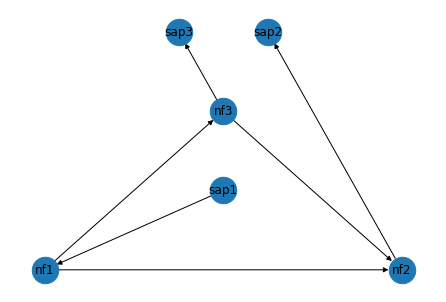

In [8]:
nx.draw_planar(sg_test,node_size=700,with_labels=True)

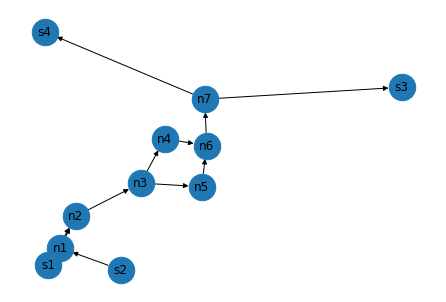

In [9]:
nx.draw_spring(sg_test_2, node_size=700, with_labels=True)

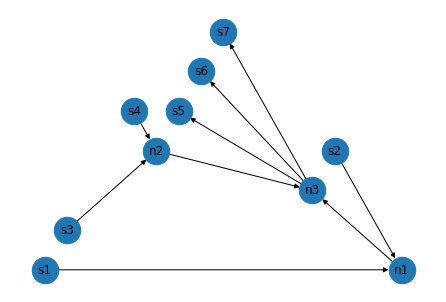

In [10]:
nx.draw_planar(sg_test_3, node_size=700, with_labels=True)

In [11]:
test_alg_data = AlgNemeth()
test_alg_data.sg = sg_test_3
test_alg_data.sc = sg_test_3sc

In [12]:
subchains = divide_into_subchains(test_alg_data)
subchains

[{'path': ['n1', 'n3', 's6'], 'delay': 0.01, 'bandwidth': 100, 'service_chains': [0, 1]}, {'path': ['s2', 'n1'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [1]}, {'path': ['n3', 's5'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [2]}, {'path': ['n2', 'n3'], 'delay': 0.01, 'bandwidth': 100, 'service_chains': [2, 3]}, {'path': ['s3', 'n2'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [2]}, {'path': ['n3', 's7'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [3]}, {'path': ['s4', 'n2'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [3]}, {'path': ['s1', 'n1'], 'delay': 0.02, 'bandwidth': 50, 'service_chains': [0]}]
[{'path': ['n1', 'n3', 's6'], 'delay': 0.01, 'bandwidth': 100, 'service_chains': [0, 1]}, {'path': ['n3', 's5'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [2]}, {'path': ['n2', 'n3'], 'delay': 0.01, 'bandwidth': 100, 'service_chains': [2, 3]}, {'path': ['n3', 's7'], 'delay': 0.01, 'bandwidth': 50, 'service_chains': [3]}]
[{'path': ['s2', 'n1']

[{'bandwidth': 50, 'delay': 0.01, 'path': ['s2', 'n1'], 'service_chains': [1]},
 {'bandwidth': 50, 'delay': 0.01, 'path': ['s3', 'n2'], 'service_chains': [2]},
 {'bandwidth': 50, 'delay': 0.01, 'path': ['s4', 'n2'], 'service_chains': [3]},
 {'bandwidth': 50, 'delay': 0.02, 'path': ['s1', 'n1'], 'service_chains': [0]},
 {'bandwidth': 100,
  'delay': 0.01,
  'path': ['n1', 'n3', 's6'],
  'service_chains': [0, 1]},
 {'bandwidth': 100,
  'delay': 0.01,
  'path': ['n2', 'n3'],
  'service_chains': [2, 3]},
 {'bandwidth': 50, 'delay': 0.01, 'path': ['n3', 's5'], 'service_chains': [2]},
 {'bandwidth': 50, 'delay': 0.01, 'path': ['n3', 's7'], 'service_chains': [3]}]

The mapping is performed by the ``map_one_nf`` procedure. It maps a leg of the SG subchains obtained with the ``divide_into_subchains`` procedure.

* it considers only those subgraphs of RG that can support all the SCs that cross this subchain; therefore it starts by finding the intersection of RG subgraphs (from the helper structure) that correspond to the service chains for this subchain
* for each candidate node, select the shortest path from the previous node in the subchain, with the reciprocal of available bandwidth as edge weight
  * this means that embedding must start with subchains that start in a SAP
* reduce to the subset that meet the link and node constraints
* compute for each candidate three metrics
  * the bandwidth metric: average bandwidth utilisation on the path and nodes
  * the mean between the ratio (delay used by path to remaining budget) and (ratio (estimated delay until earliest SC to shortest path delay until earliest SC), scaled between remaining budget and shortest path delay)
  * weighted average of resource utilisation on candidate node
* sort candidates on the sum of the three metrics in ascending order, select the first candidate.

Metric analysis:
* minimising the bandwidth and node metrics will lead to even distribution of load
* the delay metric consists of
  * the progress made on the path so far
  * the progress made towards the destination;
by minimising we increase the likelihood of meeting the delay requirement without needing backtracking.

In [13]:
def get_path_metric(alg_data, res_path, u, v, subchain):
  bw_util = subchain['bandwidth']*np.mean([1/alg_data.rg.edges[i,j]['bandwidth']
                     for i,j in zip(res_path[:-1][1:])])
  node_util = []
  for res, val in alg_data.sg.nodes[v]['reqs'].items():
    res_util = val/alg_data.rg.nodes[res_path[-1]]['reqs'][res]
    node_util.append(0 if res_util < 0.2 else (3*res_util+1)/4)
  node_util = np.mean(node_util)
  delay_metric = []
  for sc_idx in subchain['service_chains']:
    sc = alg_data.sc[sc_idx]
    path_progress = alg_data.all_pairs_delay[res_path[0]][res_path[-1]]/sc['rem_delay']
    rem_progress = alg_data.all_pairs_delay[res_path[0]][res_path[-1]] + \
                   alg_data.all_pairs_delay[res_path[-1]][sc['path'][-1]] - \
                   alg_data.all_pairs_delay[res_path[0]][sc['path'][-1]]
    rem_progress = rem_progress/(sc['rem_delay'] -\
                        alg_data.all_pairs_delay[res_path[0]][sc['path'][-1]])
    delay_metric.append(0.5*path_progress + 0.5*rem_progress)
  return bw_util+node_util+np.mean(delay_metric)

def map_one(alg_data, u, v, subchain, subchain_res_graph):
  """
  Maps one leg of a subchain consisting of the edge (u,v).
  Subchain is defined as a dictionary with keys 'path', 'delay',
  and 'service_chains'.
  Also provided is a subgraph of the resource graph corresponding
  to the service chains that are transported by this subchain.

  Returns:
  List of candidate resource graph paths sorted in increasing order of path metric.
  """
  u_rg = alg_data.node_map[u]
  if v in alg_data.node_map:
    # Both start and end nodes of the leg are mapped
    # Find k shortest paths between them. Filter out those violating constraints.
    # networkx methods don't have shortest path generators that take a function
    # to calculate the edge weight. We must make a copy of the subgraph and
    # recalculate the edge weights
    tmp_graph = nx.DiGraph()
    for i,j, data in alg_data.rg.edges:
      tmp_graph.add_edge(i,j, bandwidth=1/(1e-9+data['bandwidth']))
    candidates = []
    path_gen = nx.all_shortest_paths(tmp_graph, u_rg, alg_data.node_map[v], 'bandwidth')
    for idx, path in enumerate(path_gen):
      if idx < alg_data.k and alg_data.check_constraints(path, u, v, subchain, only_path=True):
        candidates.append(
          (get_path_metric(alg_data, res_path, u, v, subchain, subchain_res_graph),
          res_path))
    candidates.sort()
    return candidates
  candidates = []
  for n in subchain_res_graph:
    if n == u_rg: continue
    res_path = nx.dijkstra_path(subchain_res_graph, u_rg, n,
                                lambda s,t,edge_dat: 1/(1e-9+edge_dat['bandwidth'])
                                )
    if not alg_data.check_constraints(res_path, u, v, subchain):
      continue
    candidates.append(
        (get_path_metric(alg_data, res_path, u, v, subchain, subchain_res_graph),
         res_path))
  candidates.sort() # Sort candidates in increasing order of path metric
  return candidates


In [14]:
def apply_mapping(alg_data, u,v, subchain, path):
  """Map the nodes and the path to physical resources."""
  alg_data.node_map[u] = path[0]
  alg_data.node_map[v] = path[-1]
  alg_data.link_map[u,v] = path
  leg_delay = 0
  # Consume resources on the allocated links
  for i,j in zip(path[:-1][1:]):
    alg_data.rg.edges[i,j]['bandwidth'] -= subchain['bandwidth']
    leg_delay += alg_data.rg.edges[i,j]['delay']
  # Update the remaining delay of the service chains
  # transported over the leg
  for sc_idx in q['service_chains']:
    alg_data.sc[sc_idx]['rem_delay'] -= leg_delay

def clear_mapping(alg_data, u,v, subchain, path):
  """Clear the mapping of the path (u,v) and the resources it consumed."""
  alg_data.node_map[u] = None
  alg_data.node_map[v] = None
  alg_data.link_map[u,v] = None
  leg_delay = 0
  # Consume resources on the allocated links
  for i,j in zip(path[:-1][1:]):
    alg_data.rg.edges[i,j]['bandwidth'] += subchain['bandwidth']
    leg_delay += alg_data.rg.edges[i,j]['delay']
  # Update the remaining delay of the service chains
  # transported over the leg
  for sc_idx in q['service_chains']:
    alg_data.sc[sc_idx]['rem_delay'] += leg_delay

def map_sg(service_graph, resource_graph, service_chains=None):
  """
  Map the service graph onto the underlying resource graph.
  The service graph may support service chains which are simple paths
  through the service graph with end to end constraints.
  
  Returns:

  (node_mapping, link_mapping) if the mapping is successful. The resource graph
  will be updated to indicate resource consumption on nodes and links.
  
  If the mapping is not successful it returns None.
  """
  alg_data = preprocess(service_graph, resource_graph, service_chains)
  sg_div = divide_into_subchains(alg_data)
  for q in sg_div:
    # Find the intersection of the resource subgraphs corresponding to
    # all service chains transported by this subchain
    subchain_subgraph = alg_data.helper[q['service_chains'][0]]
    if len(q['service_chains']) > 1:
      for sc_idx in q['service_chains'][1:]:
        subchain_subgraph = nx.intersection(subchain_subgraph, alg_data.helper[sc_idx])
    # Stack for backtracking
    # This will store {'leg_idx', 'candidates'} for each leg of the subchain
    subchain_stack = [{'leg_idx':0}]
    while len(subchain_stack) > 0:
      crt_leg = subchain_stack[-1]
      if crt_leg['leg_idx'] == len(q['path'])-1:
        # We are actually done!
        break
      if 'candidates' not in crt_leg:
        # This is a new leg so embed it first
        u,v = path[crt_leg['leg_idx']:crt_leg['leg_idx']+2]
        # Try to embed this leg
        leg_candidates = map_one(alg_data, u, v, q, subchain_subgraph)
        if len(leg_candidates) > 0:
          (path_metric, path) = leg_candidates[0] # Tuple (path_metric, path)
          apply_mapping(alg_data, path)
          # Complete the candidates on the stack
          subchain_stack[-1]['candidates'] = leg_candidates
          # Advance to the next leg
          leg_idx = crt_leg['leg_idx']+1
          # Push on the stack
          subchain_stack.append({'leg_idx': leg_idx})
        else:
          # Could not embed the leg, so backtrack
          subchain_stack = subchain_stack[:-1]
      else:
        # There is a candidate list already, so this means we are backtracking
        # First we have to revert the previous allocation
        prev_path = crt_leg['candidates'][0][1]
        # Update the remaining delay of the service chains
        # transported over the leg
        leg_delay = sum(alg_data.rg.edges[i,j]['delay']
                        for i,j in zip(prev_path[:-1][1:]))
        for sc_idx in q['service_chains']:
          alg_data.sc[sc_idx]['rem_delay'] += leg_delay
        # Try the next candidate
        if len(crt_leg['candidates']) > 1:
          crt_leg['candidates'] = crt_leg['candidates'][1:]
          (_, path) = crt_leg['candidates'][0]
          apply_mapping(alg_data, path)
          # Advance to the next leg
          leg_idx = crt_leg['leg_idx']+1
          # Push on the stack
          subchain_stack.append({'leg_idx': leg_idx})
        else:
          # No more candidates left for this leg, backtrack
          subchain_stack = subchain_stack[:-1]
    if len(subchain_stack) == 0:
      # Unable to embed this subchain, this means failure
      return None
  # Consume all the node resources
  for n, data in alg_data.sg.nodes(data=True):
    if n not in alg_data.node_map:
      raise Exception("Service Graph node", n, "not mapped!")
    for req, val in data['reqs'].items():
      alg_data.rg.nodes[alg_data.node_map[n]][req] -= val
  return alg_data.node_mapping, alg_data.link_mapping

In [15]:
for n, data in sg_test.nodes(data=True):
  print(n, data)

sap1 {'type': 'sap', 'ta': 0}
nf1 {'type': 'nf'}
nf2 {'type': 'nf'}
nf3 {'type': 'nf'}
sap2 {'type': 'sap', 'ta': 1}
sap3 {'type': 'sap', 'ta': 0}


# Service Graph generation

Directed graph with the following structure:
* a set of input nodes
* each input node may be followed by 0 or more pre-processing steps, creating _input chains_
* the input chains are then processed by a set of fan-in and fan-out levels
  * each fan-in level takes $k_{in}$ input chains and aggregates them
  * each fan-out level outputs $k_{out}$ chains
  * __OBS__ all input chains must be aggregated eventually
* the number of fan-in/out levels is a random variable, as are $k_{in}$ and $k_{out}$
* the sequence of fan-in/out levels is random: a fan-in level may be followed by a fan-out level or another fan-in level
* fan-in/out levels may also create outputs that end a chain.



In [137]:
from random import seed, random, randint, sample, choice

class ServiceGraphGenerator():
  def __init__(self, **params):
    self.input_range = params.setdefault('input_range', (2,4))
    self.output_range = params.setdefault('output_range', (1,3))
    self.preproc_stages = params.setdefault('preproc', 2)
    self.k_in = params.setdefault('fanin', 2)
    self.k_out = params.setdefault('fanout', 2)
    self.max_levels = params.setdefault('maxlevels', 3)
    self.nf_per_level = params.setdefault('nf_per_level', 2)
    
  def generate(self, random_seed):
    seed(random_seed)
    # Dictionary to store nodes
    sg = nx.DiGraph()
    node_id = 0
    # Create input chains
    input_chains = []
    for idx in range(randint(*self.input_range)):
      node = {'id':node_id, 'type': 'sap', 'reqs':None,
              'preproc':randint(0, self.preproc_stages)}
      sg.add_node(node_id, **node)
      node_id += 1
      input_chains.append(node)
    processing = []
    layer_one = []
    unprocessed_input_chains = [n['id'] for n in input_chains]
    # Start with a fan-in layer that aggregates some of the input chains
    for n_idx in range(randint(1, len(input_chains))):
      agg_input = min(randint(0,self.k_in), len(unprocessed_input_chains))
      if agg_input == 0: continue
      input_nodes = sample(range(len(unprocessed_input_chains)), agg_input)
      agg_node = {'id':node_id, 'type': 'nf', 'reqs':None}
      # Connect to nodes upstream
      sg.add_node(node_id, **agg_node)
      for upstream in input_nodes:
        sg.add_edge(unprocessed_input_chains[upstream], node_id) # TODO edge attrs
      layer_one.append(agg_node)
      node_id += 1
      # Update the list of unprocessed input chains
      for i in sorted(input_nodes, reverse=True):
        del unprocessed_input_chains[i]
    processing.append(layer_one)
    unprocessed_nodes = unprocessed_input_chains
    for layer in range(1, self.max_levels):
      layer = []
      unprocessed_nodes += [n['id'] for n in processing[-1]]
      node_idx = 0
      layer_size = randint(1, max(self.nf_per_level,len(unprocessed_nodes)))
      while node_idx < layer_size:
        # Is this a fan-in or fan-out node
        if random() < 0.5:
          # fan-in
          agg_input = min(randint(0,self.k_in), len(unprocessed_nodes))
          if agg_input == 0: continue
          input_nodes = sample(range(len(unprocessed_nodes)), agg_input)
          agg_node = {'id':node_id, 'type': 'nf', 'reqs':None}
          # Connect to nodes upstream
          sg.add_node(node_id, **agg_node)
          for upstream in input_nodes:
            sg.add_edge(unprocessed_nodes[upstream], node_id) # TODO edge attrs          
          layer.append(agg_node)
          node_id += 1
          # Update the list of unprocessed input chains
          for i in sorted(input_nodes, reverse=True):
            del unprocessed_nodes[i]
          node_idx += 1
        else:
          # fan-out. Generate a few nodes and select a previous node as input
          fan_out_number = randint(0, min(self.k_out, layer_size-node_idx))
          if fan_out_number == 0: continue
          input_node = choice(range(len(unprocessed_nodes)))
          for i in range(fan_out_number):
            node = {'id':node_id, 'type':'nf', 'reqs':None}
            sg.add_node(node_id, **node)
            sg.add_edge(unprocessed_nodes[input_node], node_id)
            node_id += 1
            layer.append(node)
          del unprocessed_nodes[input_node]
          node_idx += fan_out_number
        if len(unprocessed_nodes) == 0: break
      processing.append(layer)
    # The processing layers are finished, add the output nodes
    # If there are more nodes on the last layer than output nodes,
    # add another fan-in layer
    output_nodes = randint(*self.output_range)
    if len(processing[-1]) > output_nodes:
      remaining = [n['id'] for n in processing[-1]]
      layer = []
      n_idx = 0
      while n_idx < output_nodes and len(remaining) > 0:
        # fan-in
        agg_input = min(randint(1,self.k_in), len(remaining))
        input_nodes = sample(range(len(remaining)), agg_input)
        agg_node = {'id':node_id, 'type': 'nf', 'reqs':None}
        # Connect to nodes upstream
        sg.add_node(node_id, **agg_node)
        for upstream in input_nodes:
          sg.add_edge(remaining[upstream], node_id) # TODO edge attrs
        layer.append(agg_node)
        node_id += 1
        # Update the list of unprocessed input chains
        for i in sorted(input_nodes, reverse=True):
          del remaining[i]
        n_idx += 1
      processing.append(layer)
    output_layer = []
    for n in processing[-1]:
      # Add an output node
      output_node = {'id':node_id, 'type':'sap', 'reqs':None}
      sg.add_node(node_id, **output_node)
      sg.add_edge(n['id'], node_id) # TODO edge attrs
      node_id += 1
      output_layer.append(output_node)
    processing.append(output_layer)
    # If there are unprocessed nodes, connect them to a random node on the next
    # layer
    for n in unprocessed_nodes:
      # What layer is this on?
      n_idx = 0
      for lidx, layer in enumerate(processing):
        if n in [ln['id'] for ln in layer]:
          n_idx = lidx
          break
      # Connect to a random node on the next layer
      next = choice(processing[n_idx+1])['id']
      sg.add_edge(n, next)
    processing = [input_chains] + processing
    pos = {}
    biggest_layer = max(len(layer) for layer in processing)
    middle_line = biggest_layer/2
    l_xpos = 0
    for layer in processing:
      l_size = len(layer)
      l_ypos = middle_line-l_size/2
      for n in layer:
        pos[n['id']] = (l_xpos, l_ypos)
        l_ypos += 100
      l_xpos += 100
    return sg, pos

In [146]:
params = {
    'input_range':(2,4),
    'output_range':(1,2),
    'preproc': 2,
    'fanin': 3,
    'fanout': 3,
    'maxlevels': 3,
    'nf_per_level': 3
}
gen = ServiceGraphGenerator(**params)

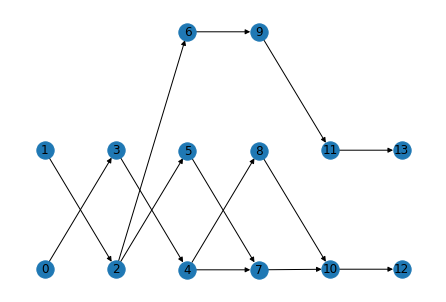

In [152]:
sg, pos = gen.generate(2)
nx.draw(sg, pos, with_labels=True)